In [ ]:
!pip3 install pickle5

import random
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
import pickle5 as pickle
from datetime import datetime 
from pylab import savefig
from matplotlib import pyplot as plt
from google.colab import drive 
from numpy import load, save
from keras import regularizers, activations
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

Importowanie bibliotek.

In [ ]:
drive.mount('/content/gdrive')
us8k_df = pd.read_pickle("/content/gdrive/MyDrive/Licencjat/us8k_df.pkl")
with open("/content/gdrive/MyDrive/Licencjat/us8k_df_augmentation.pkl", "rb") as fh: 
  usk_df_augmentation = pickle.load(fh)

sound_classes_short = ['WEN', 'KLAK', 'DZIE', 'PIES', 'WIER',
                      'SIL', 'STRZ', 'MŁOT', 'SYR', 'UL']   

Mounted at /content/gdrive


Połaczenie z Google Drive'm oraz wczytanie plików w formacie "pickle" zawierających zapis spektrogramów przeskalowanych w skali melowej wraz z odpowiadającymi oznaczeniami folderów i klas.

Budowa architektury modelu bazowego.

In [ ]:
def init_model():
    model1 = Sequential()
    
    #layer-1
    model1.add(Conv2D(filters=24, kernel_size=5, input_shape=(128, 128, 1)))
    model1.add(MaxPooling2D(pool_size=(4,2)))
    model1.add(Activation(activations.relu))
    
    #layer-2
    model1.add(Conv2D(filters=48, kernel_size=5))
    model1.add(MaxPooling2D(pool_size=(4,2)))
    model1.add(Activation(activations.relu))
    
    #layer-3
    model1.add(Conv2D(filters=48, kernel_size=5))
    model1.add(Activation(activations.relu))
    
    model1.add(Flatten())
    
    #layer-4
    model1.add(Dropout(0.5))
    model1.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-3)))

    #layer-5
    model1.add(Dropout(0.5))
    model1.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-3)))

    # compile
    model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))
    
    return model1

Inicjalizacja modelu.

In [ ]:
model = init_model()
model.summary()

Funkcja dzielenia folderów na zbior walidacyjny, testowy oraz treningowy.

In [ ]:
def train_test_split(fold_k, data, data_augmented, X_dim=(128, 128, 1)):
  train_set = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
  train_set.remove(fold_k)
  val_fold = random.choice(train_set)
  
  X_train = data_augmented[data_augmented.folder_id != val_fold]
  X_train = np.stack(X_train[X_train.folder_id != fold_k].melspectrogram.to_numpy())
  X_val = np.stack(data[data.folder_id == val_fold].melspectrogram.to_numpy())
  X_test = np.stack(data[data.folder_id == fold_k].melspectrogram.to_numpy())

  y_train = data_augmented[data_augmented.folder_id != fold_k]
  y_train = y_train[y_train.folder_id != val_fold].audio_class_id.to_numpy()
  y_val = data[data.folder_id == val_fold].audio_class_id.to_numpy()
  y_test = data[data.folder_id == fold_k].audio_class_id.to_numpy()

  XX_train = X_train.reshape(X_train.shape[0], *X_dim)
  XX_val = X_val.reshape(X_val.shape[0], *X_dim)
  XX_test = X_test.reshape(X_test.shape[0], *X_dim)
  
  yy_train = to_categorical(y_train)
  yy_val = to_categorical(y_val)
  yy_test = to_categorical(y_test)
  
  return XX_train, XX_val, XX_test, yy_train, yy_val, yy_test

Funkcja rysująca wykres zmiany dokładności i straty w funkcji liczby epok.

In [ ]:
def show_results(tot_history):
    for i, history in enumerate(tot_history):
        plt.figure(figsize=(15,5))

        plt.subplot(121)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Dokładność')
        plt.xlabel('Epoka')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.title("Dokładność modelu na epokę")

        plt.subplot(122)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Strata')
        plt.xlabel('Epoka')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.title("Strata modelu na epokę")
            
        plt.show()

        print('\tMaksymalna dokładność zbioru walidacyjnego: %.4f %%' % (np.max(history.history['val_accuracy']) * 100))
        print('\tMinimalna strata zbioru walidacyjnego: %.5f' % np.min(history.history['val_loss']))

Funkcja zwracająca dokładność modelu dla danych testowych oraz macierz pomyłek dla tych danych.

In [ ]:
def evaluate(model, XX_test, yy_test):
    y_prob = model.predict(XX_test, verbose=0)
    y_pred = np.argmax(y_prob, 1)
    y_true = yy_test
    y_true = np.argmax(y_true, axis=1)

    score, accuracy = model.evaluate(XX_test, yy_test, batch_size=100, verbose=0)

    print("\nDokładność = {:.2f}".format(accuracy))

    cm = confusion_matrix(y_true, y_pred)
    
    return accuracy, cm

Każdy folder po kolei jest wpisywany jako folder testowy.

In [ ]:
TEST_FOLDER = '1'

X_train, X_val, X_test, y_train, y_val, y_test = train_test_split(TEST_FOLDER, us8k_df, usk_df_augmentation)

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((28212, 128, 128, 1),
 (28212, 10),
 (806, 128, 128, 1),
 (806, 10),
 (873, 128, 128, 1),
 (873, 10))

Proces trenowania.

In [ ]:
history_store = []

start = datetime.now()
    
history = model.fit(X_train, y_train, 
                    epochs=50,
                    batch_size=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(restore_best_weights=True, patience=15)])
end = datetime.now()
history_store.append(history)
        

Wyświetlanie rysunków.

In [ ]:
show_results(history_store)

Badanie dokładności dla danych testowych oraz zwrócenie macierzy pomyłek dla danego folderu.

In [ ]:
accuracy, cm = evaluate(model, X_test, y_test)


Dokładność = 0.64


Inicjalizowana jest zmienna "CM" oznaczająca macierz pomyłek. Zważając na to, że proces trenowania trwa chwilę, a trzeba go powtórzyć co najmniej 10 razy, macierz po zaktualizowaniu można zapisać, a następnie wczytać. Wówczas wykonywana jest jedynie część z następnych operacji - po zwróceniu macierzy pomyłek dla danego folderu, zapisanego w "cm" nie inicjalizujemy znowu "CM", a jedynie aktualizujemy jego wartości, dodając te z "cm".

In [ ]:
CM = 0

In [ ]:
cm

In [ ]:
CM = CM + cm
save('confusion_matrix.npy', CM)

In [ ]:
CM = load('confusion_matrix.npy')

In [ ]:
df_cm = pd.DataFrame(CM, sound_classes_short, sound_classes_short)
sn.set(font_scale=0.8)
svm = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt=".0f", cbar_kws={'label': 'Liczba zaklasyfikowanych próbek'})
plt.xlabel('Klasa prognozowana')
plt.ylabel('Klasa rzeczywista')
plt.figure(figsize = (20,14))
figure = svm.get_figure()    
figure.savefig('svm_conf.png', dpi=400)
plt.show()

Wczytywanie macierzy pomyłek dla modelu bazowego

In [ ]:
base_model_CM = load('confusion_matrix_standard.npy')

Różnica w macierzach pomyłek modelu bazowego z syntentycznymi danymi i modelu bazowego.

In [ ]:
new_matrix = np.subtract(CM, base_model_CM)

Wyświetlnie różnicy macierzy pomyłek.

In [ ]:
df_cm = pd.DataFrame(new_matrix,sound_classes_short, sound_classes_short)
sn.set(font_scale=0.8)
svm = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10}, fmt=".0f", cbar_kws={'label': 'Różnica w liczbie zaklasyfikowanych próbek'})
plt.xlabel('Klasa prognozowana')
plt.ylabel('Klasa rzeczywista')
plt.figure(figsize = (20,14))
figure = svm.get_figure()    
figure.savefig('svm_conf.png', dpi=400)
plt.show()

Wyświetlenie wykresu pudełkowego dla wyników uzyskanych podczas trenowania wszystkich modeli.

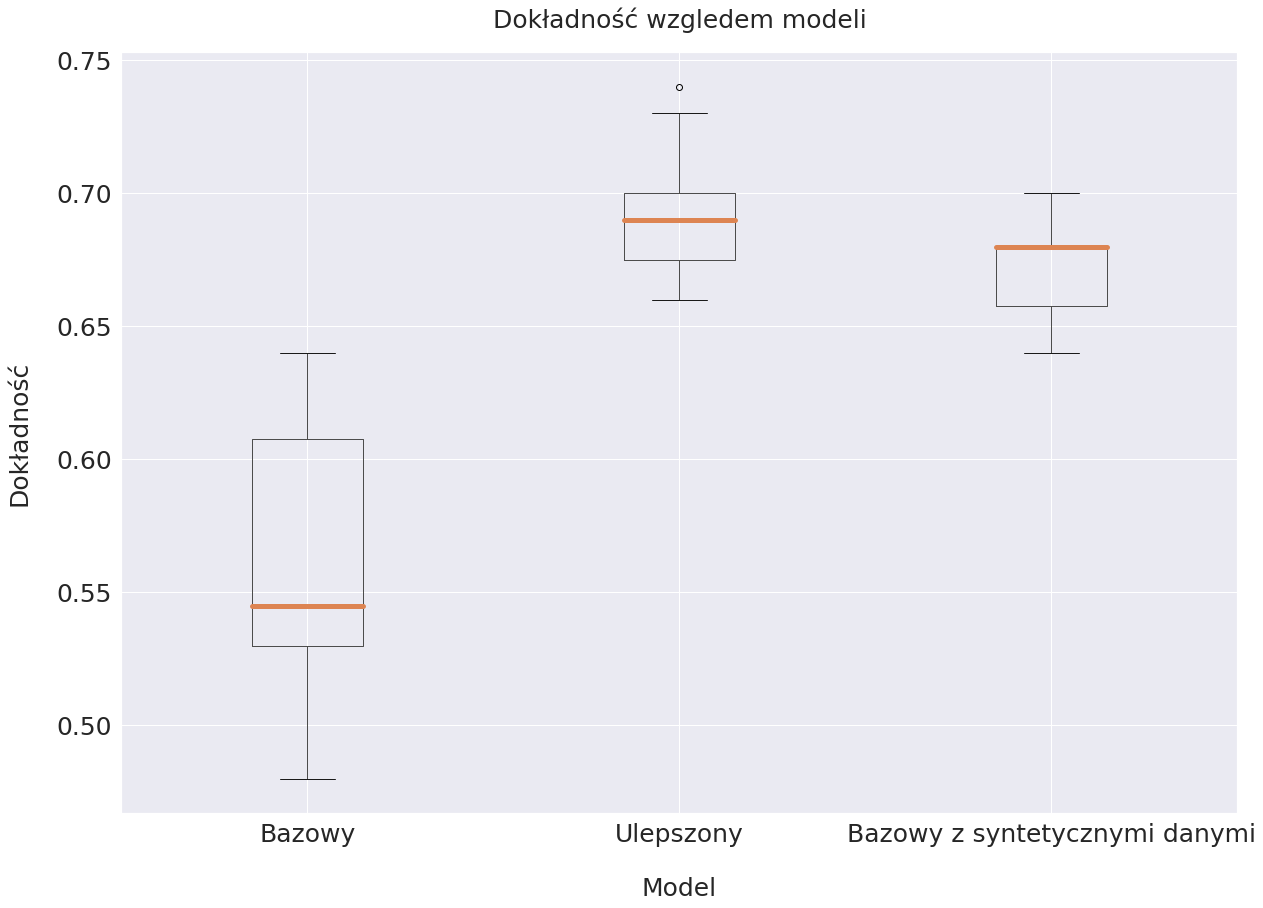

In [ ]:
df_new = pd.DataFrame()
df_new['Bazowy'] = [0.55, 0.61, 0.54, 0.48, 0.64, 0.53, 0.53, 0.51, 0.63, 0.6]
df_new['Ulepszony'] = [0.7, 0.69, 0.66, 0.69, 0.69, 0.7, 0.67, 0.67, 0.74, 0.73]
df_new['Bazowy z syntetycznymi danymi'] = [0.68, 0.65, 0.68, 0.65, 0.68, 0.68, 0.69, 0.64, 0.7, 0.68]

df_box = pd.DataFrame(df_new)

boxplot = df_box.boxplot(figsize=(20, 14),  
                         medianprops={'linestyle': '-', 'linewidth': 5}, fontsize=25)
boxplot.set_ylabel('Dokładność', fontsize=25, labelpad=25)
boxplot.set_xlabel('Model', fontsize=25, labelpad=30)
boxplot.set_title('Dokładność wzgledem modeli', fontsize=25, pad=25)
figure = boxplot.get_figure()    
figure.savefig('box_plot.png', dpi=400)

Wyświetlenie median i odchyleń standardowych dla poszczególnych modeli.

In [ ]:
median_base = np.median(df_new['Bazowy'])
median_impr = np.median(df_new['Ulepszony'])
median_aug = np.median(df_new['Bazowy z syntetycznymi danymi'])

median_base, median_impr, median_aug

(0.545, 0.69, 0.68)

In [ ]:
std_dev_base = np.std(df_new['Bazowy'])
std_dev_impr = np.std(df_new['Ulepszony'])
std_dev_aug = np.std(df_new['Bazowy z syntetycznymi danymi'])

std_dev_base, std_dev_impr, std_dev_aug

(0.0515363949069005, 0.02416609194718913, 0.018466185312619378)